In [1]:
import os, glob, json
from copy import deepcopy
import numpy as np
import pandas as pd
import corner
import h5py
import prospect.io.read_results as reader
from prospect.plotting import FigureMaker
from prospect.plotting.utils import best_sample
from sedpy import observate

import matplotlib.pyplot as plt
from matplotlib.lines import Line2D

import seaborn as sns

from scipy.stats import gaussian_kde

In [2]:
def computeConfidenceIntervals(result, alphas=[0.682, 0.954, 0.996], **kwargs):
    '''
    result dictionary from prospector
    '''
    chain, labels = result['chain'], result['theta_labels']
    return {str(a):CI(chain, labels, a, **kwargs) for a in alphas}                                        


def CI(chain, labels, alpha, verbose=False, log=None):
    '''
    Calculate the confidence intervals around the median
    of each input parameter in the chain
    
    chain [Array] : np array of output samples from the MCMC
    alpha [float] : confidence level to compute
    center [string] : techniique to get central value of distribution
                      that the CI is based around. Supported options are
                      'median', 'mode', 'mean'
    '''
    
    if log is None:
        log = [False]*len(labels) # don't log any of the labels
    
    forFile = 'Confidence Intervals: \n\n'
    outdict = {}
    for col, label, isLogged in zip(chain.T, labels, log):
        
        if isLogged:
            col = np.log10(col)
            label = f'log10({label})'
        
        middle = 0.5
        q1 = np.quantile(col, middle-(alpha/2))
        q2 = np.quantile(col, middle)
        q3 = np.quantile(col, middle+(alpha/2))
        
        forFile += f'{label} {alpha*100}% CI:\n'
        if verbose:
            forFile += f'         Q1: {q1}\n'
            forFile += f'Q2 (median): {q2}\n'
            forFile += f'         Q3: {q3}\n'
        forFile += f'{label} = {q2} (+{q3-q2}, -{q2-q1})'
        forFile += '\n'
        
        outdict[label] = {'median':q1,
                          'negErr':q2-q1,
                          'posErr':q3-q2}
        
    #print(forFile)
    
    return outdict 

In [3]:
outdir = os.path.join(os.getcwd(), 'data', 'out', '*h5')
outfiles = glob.glob(outdir)

allci = {}
allResults = {}
allObs = {}
alldata = {}
for h5file in outfiles:
    res, obs, model = reader.results_from(h5file)
    #cfig = reader.subcorner(res, logify=['mass', 'tau'], bins=20, smooth=1, color='darkred')
    #cfig.suptitle(obs['objid'], fontsize=18)
    
    #fig = reader.traceplot(res)
    #fig.suptitle(obs['objid'], fontsize=18)
    
    # compute some stats
    log = [True, False, False, False, False]
    ci = computeConfidenceIntervals(res, log=log)
    
    allci[obs['objid']] = ci
    allResults[obs['objid']] = res
    allObs[obs['objid']] = obs
    alldata[obs['objid']] = {label:chain for label, chain in zip(res['theta_labels'], np.median(res['chain'], axis=0).T)}

## Comparing Median Values

In [4]:
subdict = {'median':[],
            'negErr_1s':[],
             'posErr_1s':[],
          'negErr_2s':[],
             'posErr_2s':[],
          'negErr_3s':[],
             'posErr_3s':[],
          'data': []
          }

dfdict = {'log10(mass)':deepcopy(subdict),
          'logzsol':deepcopy(subdict),
          'dust2':deepcopy(subdict),
          'tage':deepcopy(subdict),
          'tau':deepcopy(subdict),
          'names':[]}

cis = ['0.682', '0.954', '0.996']
for tde in allci:
    for key in dfdict:
        if key == 'names':
            dfdict[key].append(tde)
        else:
            for subkey in subdict:
                
                if '1s' in subkey:
                    ci = cis[0]
                    allci_subkey = subkey.split('_')[0]
                elif '2s' in subkey:
                    ci = cis[1]
                    allci_subkey = subkey.split('_')[0]
                elif '3s' in subkey:
                    ci = cis[2]
                    allci_subkey = subkey.split('_')[0]
                else:
                    ci = cis[0] # just take the median from the 1sig calc
                    allci_subkey = 'median'
                
                dfdict[key][subkey].append(allci[tde][ci][key][allci_subkey])

In [5]:
for key in dfdict:
    if key == 'names': continue
    dfdict[key] = pd.DataFrame(dfdict[key])
    dfdict[key]['name'] = dfdict['names']

In [6]:
subdict = {'median':[],
            'negErr':[],
             'posErr':[],
          }

true = {'true_mass':deepcopy(subdict),
       'true_z': deepcopy(subdict),
       'true_dust': deepcopy(subdict),
       'true_age': deepcopy(subdict),
       'true_tau': deepcopy(subdict),
       'name':[]}

truedata = pd.read_csv('data/catalog.txt', skiprows=6, delimiter='\t', 
                       names=['name', 'true_mass', 'u_r', 'true_dust', 'true_age', 'true_tau', 'true_z'],
                       usecols=range(7),
                      index_col=None)

for key in true:
    for val in truedata[key]:
        
        if key == 'name':
            true['name'].append(val)
            continue
        
        split1 = val.split('_')
        split2 = split1[1].split('^')

        med = split1[0][2:-1]
        if med[0] == '{':
            med = float(med.replace('{', '-'))
        else:
            med = float(med)

        upper = float(split2[0][1:-1])
        lower = float(split2[1][1:-2])
        
        true[key]['median'].append(med)
        true[key]['negErr'].append(lower)
        true[key]['posErr'].append(upper)

for key in true:
    if key == 'name': continue
    true[key] = pd.DataFrame(true[key])
    true[key]['name'] = true['name']    

In [7]:
true.keys(), dfdict.keys()

(dict_keys(['true_mass', 'true_z', 'true_dust', 'true_age', 'true_tau', 'name']),
 dict_keys(['log10(mass)', 'logzsol', 'dust2', 'tage', 'tau', 'names']))

In [8]:
comb = {}
keys = ['log10(Mass)', 'Z', 'Dust', 'Age', 'tau']
for d, t, key in zip(dfdict.values(), true.values(), keys):
    df = pd.merge(d, t, on='name', suffixes=['_Franz', '_vanVelzen']) 
    comb[key] = df

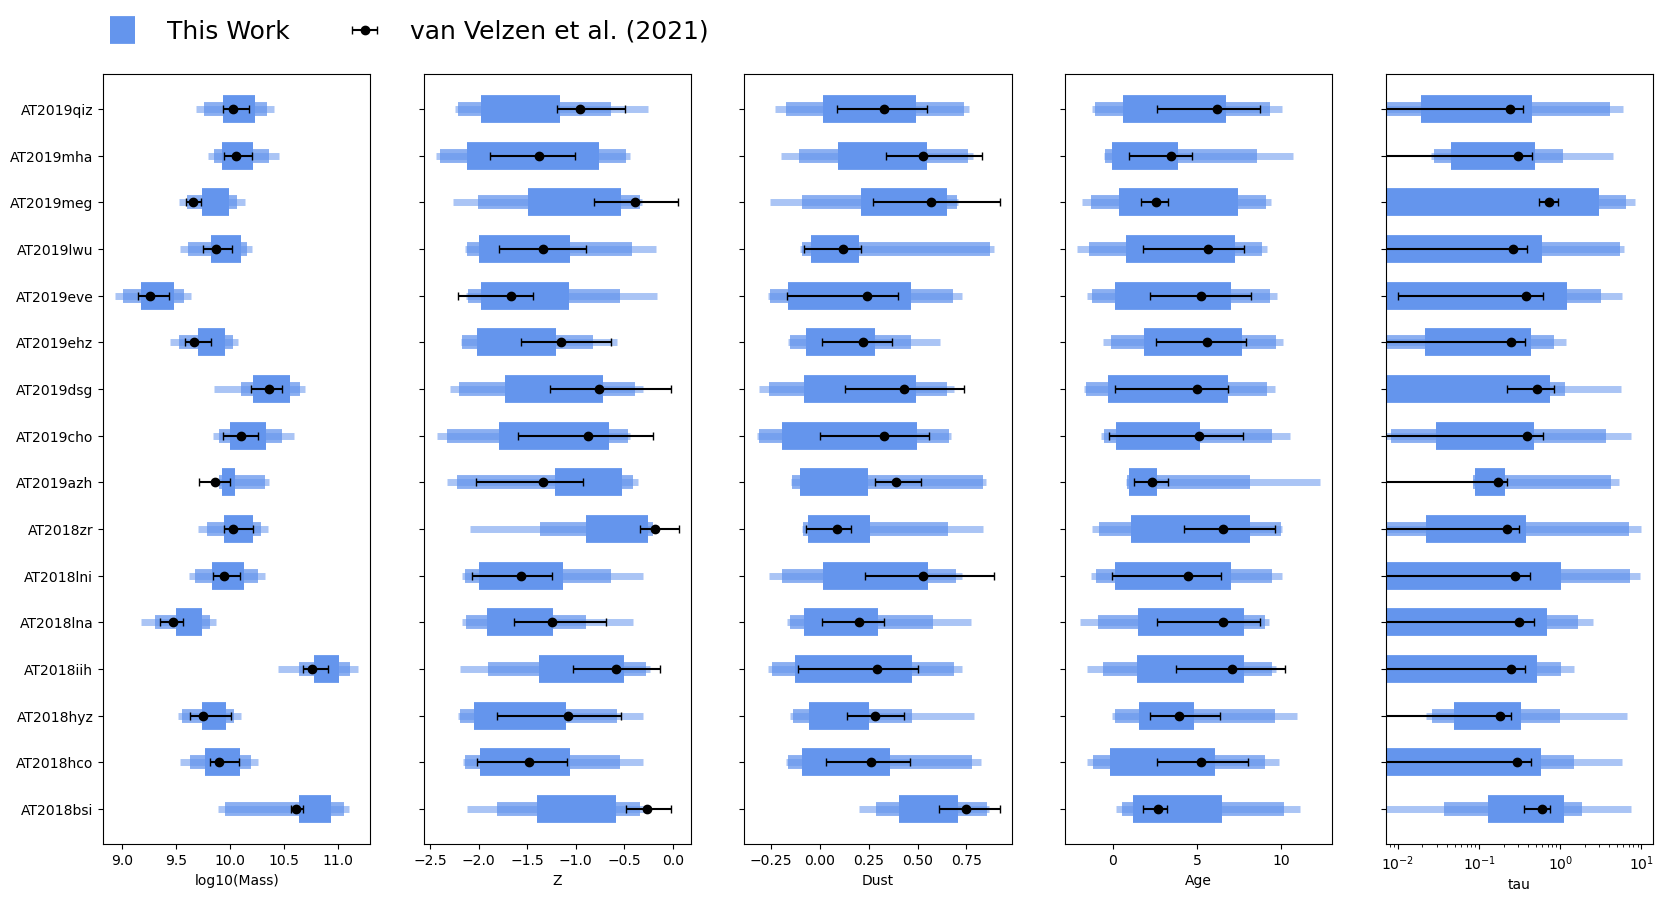

In [17]:
fig, ax = plt.subplots(1,5, sharey=True, figsize=(20,10))
for ii, key in enumerate(comb):
    df = comb[key].sort_values('name', inplace=False)
    ax[ii].errorbar(df.median_Franz, df.name, xerr=[df.negErr_1s, df.posErr_1s], fmt='cornflowerblue', label='This Work', elinewidth=20, marker=None, linestyle='None')
    ax[ii].errorbar(df.median_Franz, df.name, xerr=[df.negErr_2s, df.posErr_2s], fmt='cornflowerblue', alpha=0.75, elinewidth=10, marker=None, linestyle='None')
    ax[ii].errorbar(df.median_Franz, df.name, xerr=[df.negErr_3s, df.posErr_3s], fmt='cornflowerblue', alpha=0.55, elinewidth=5, marker=None, linestyle='None')
    #pos = list(range(len(df.name)))
    #print(len(pos))
    #print(len(df.median_Franz))
    #ax[ii].violinplot(df.median_Franz, pos)
    ax[ii].errorbar(df.median_vanVelzen, df.name, xerr=[df.negErr, df.posErr], fmt='ko', label='van Velzen et al. (2021)', capsize=3)
    ax[ii].set_xlabel(key)
    
ax[0].legend(ncols=2, bbox_to_anchor=(2.35,1.1), fontsize=18, frameon=False)
ax[-1].set_xscale('log')

## Look at other results

In [10]:
# read in the json files

colordata = {'u-r color': [],
             'upper': [],
             'lower': [],
             'name': []}
for jfile in glob.glob('data/model/*.json'):
    with open(jfile, 'r') as j:
        data = json.load(j)
        
    colordata['u-r color'].append(data['u_r'][0])
    colordata['upper'].append(data['u_r'][1])
    colordata['lower'].append(data['u_r'][2])
    colordata['name'].append(os.path.basename(jfile).split('_')[0])
    
colordata = pd.DataFrame(colordata)    

colordata

,u-r color,upper,lower,name
0,2.056795,0.036686,0.034750,AT2018hyz
1,2.272846,0.018703,0.030275,AT2018bsi
2,2.360765,0.048442,0.093172,AT2019dsg
3,3.030974,0.091418,0.074372,AT2018iih
4,2.755709,0.044660,0.080823,AT2019cho
5,2.267370,0.019054,0.045225,AT2019lwu
6,2.369263,0.071904,0.111508,AT2018lni
7,1.908313,0.022687,0.029842,AT2019azh
8,2.209607,0.063761,0.077001,AT2019ehz
9,2.073534,0.087027,0.092361,AT2019eve


In [11]:
truecolor = {'u-r color': [],
             'upper': [],
             'lower': [],
             'name': np.array(truedata['name'])}

for color in truedata['u_r']:

    split1 = color.split('_')
    split2 = split1[1].split('^')

    med = split1[0][2:-1]
    if med[0] == '{':
        med = float(med.replace('{', '-'))
    else:
        med = float(med)

    upper = float(split2[0][1:-1])
    lower = float(split2[1][1:-2])
    
    truecolor['u-r color'].append(med)
    truecolor['upper'].append(upper)
    truecolor['lower'].append(lower)
    
truecolor = pd.DataFrame(truecolor)

truecolor

,u-r color,upper,lower,name
0,2.36,0.08,0.05,AT2018zr
1,2.17,0.04,0.03,AT2018bsi
2,1.88,0.07,0.06,AT2018hco
3,2.32,0.07,0.05,AT2018iih
4,1.91,0.03,0.05,AT2018hyz
5,1.97,0.08,0.09,AT2018lni
6,1.98,0.07,0.09,AT2018lna
7,2.08,0.07,0.10,AT2019cho
8,2.09,0.08,0.06,AT2019bhf
9,1.80,0.04,0.03,AT2019azh


In [12]:
truedata

,name,true_mass,u_r,true_dust,true_age,true_tau,true_z
0,AT2018zr,${10.03}_{0.18}^{0.09}$,${2.36}_{0.08}^{0.05}$,${0.09}_{0.07}^{0.16}$,${6.56}_{3.07}^{2.35}$,${0.22}_{0.09}^{0.25}$,$-{0.19}_{0.25}^{0.15}$
1,AT2018bsi,${10.61}_{0.06}^{0.05}$,${2.17}_{0.04}^{0.03}$,${0.75}_{0.17}^{0.14}$,${2.67}_{0.58}^{0.89}$,${0.59}_{0.15}^{0.23}$,$-{0.27}_{0.25}^{0.21}$
2,AT2018hco,${9.90}_{0.18}^{0.09}$,${1.88}_{0.07}^{0.06}$,${0.26}_{0.20}^{0.23}$,${5.25}_{2.79}^{2.62}$,${0.29}_{0.15}^{0.40}$,$-{1.48}_{0.39}^{0.54}$
3,AT2018iih,${10.76}_{0.15}^{0.09}$,${2.32}_{0.07}^{0.05}$,${0.29}_{0.21}^{0.40}$,${7.10}_{3.11}^{3.33}$,${0.25}_{0.12}^{0.30}$,$-{0.59}_{0.46}^{0.44}$
4,AT2018hyz,${9.75}_{0.26}^{0.12}$,${1.91}_{0.03}^{0.05}$,${0.28}_{0.15}^{0.14}$,${3.95}_{2.43}^{1.73}$,${0.18}_{0.07}^{0.20}$,$-{1.08}_{0.54}^{0.73}$
5,AT2018lni,${9.94}_{0.15}^{0.10}$,${1.97}_{0.08}^{0.09}$,${0.53}_{0.36}^{0.30}$,${4.49}_{1.95}^{4.53}$,${0.28}_{0.14}^{0.37}$,$-{1.56}_{0.31}^{0.51}$
6,AT2018lna,${9.47}_{0.09}^{0.12}$,${1.98}_{0.07}^{0.09}$,${0.20}_{0.13}^{0.19}$,${6.55}_{2.19}^{3.92}$,${0.31}_{0.17}^{0.35}$,$-{1.24}_{0.55}^{0.40}$
7,AT2019cho,${10.10}_{0.16}^{0.17}$,${2.08}_{0.07}^{0.10}$,${0.33}_{0.23}^{0.33}$,${5.13}_{2.62}^{5.32}$,${0.39}_{0.22}^{0.41}$,$-{0.87}_{0.66}^{0.72}$
8,AT2019bhf,${10.21}_{0.12}^{0.15}$,${2.09}_{0.08}^{0.06}$,${0.72}_{0.36}^{0.20}$,${3.20}_{1.17}^{1.97}$,${0.45}_{0.26}^{0.35}$,$-{0.99}_{0.65}^{0.61}$
9,AT2019azh,${9.86}_{0.14}^{0.15}$,${1.80}_{0.04}^{0.03}$,${0.39}_{0.13}^{0.11}$,${2.32}_{0.94}^{1.07}$,${0.17}_{0.05}^{0.18}$,$-{1.34}_{0.41}^{0.69}$


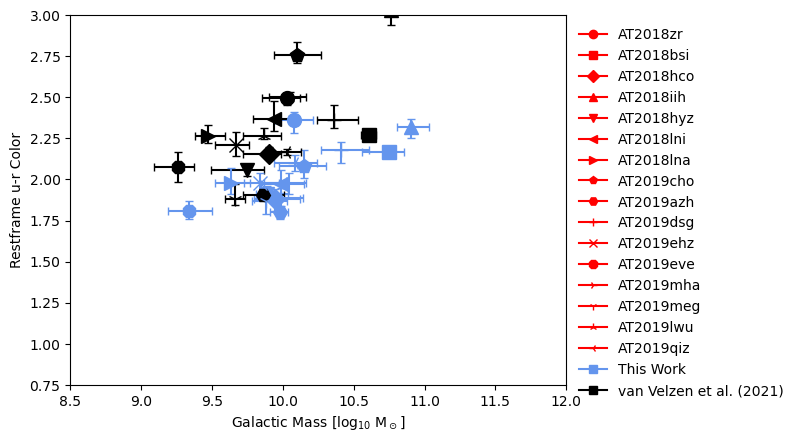

In [18]:
colors = pd.merge(truecolor, colordata, on='name', suffixes=['_Franz', '_vanVelzen']) 

colors['markers'] = ['o', 's', 'D', '^', 'v', '<', '>', 'p', '*', 'H', '+', 'x', '8', '4', '1', '2', '3']

colors = pd.merge(colors, comb['log10(Mass)'], on='name')

fig, ax = plt.subplots()
legendlines = []
for i, row in colors.iterrows():
    ax.errorbar([row['median_Franz']], [row['u-r color_Franz']], yerr=([row.upper_Franz], [row.lower_Franz]), 
                xerr=([row.posErr_1s], [row.negErr_1s]), marker=row.markers, color='cornflowerblue', capsize=3, markersize=10)
    ax.errorbar([row['median_vanVelzen']], [row['u-r color_vanVelzen']], yerr=([row.upper_vanVelzen], [row.lower_vanVelzen]), 
                xerr=([row.posErr], [row.negErr]), marker=row.markers, color='k', capsize=3, markersize=10)
    legendlines.append(Line2D([0],[0],marker=row.markers,color='red'))
    
legendlines.append(Line2D([0], [0], marker='s', color='cornflowerblue'))
legendlines.append(Line2D([0], [0], marker='s', color='k'))
    

ax.set_ylim(0.75, 3)
ax.set_xlim(8.5, 12)
ax.set_ylabel('Restframe u-r Color')
ax.set_xlabel(r'Galactic Mass [log$_{10}$ M$_\odot$]')
ax.legend(legendlines, list(colors.name)+['This Work', 'van Velzen et al. (2021)'], bbox_to_anchor=(1, 1), frameon=False);

# Try out a violin plot

In [14]:
subdict = {'name': [],
           'data': []
          }

dfdict = {'mass':deepcopy(subdict),
          'logzsol':deepcopy(subdict),
          'dust2':deepcopy(subdict),
          'tage':deepcopy(subdict),
          'tau':deepcopy(subdict)}

allkeys = list(dfdict.keys())
for key in allkeys:
    for name in alldata:

        dfdict[key]['name'].append(name)
        dfdict[key]['data'].append(alldata[name][key])

In [15]:
combviolin = {}
keys = ['log10(Mass)', 'Z', 'Dust', 'Age', 'tau']
for d, t, key in zip(dfdict.values(), true.values(), keys):
    newdata = pd.DataFrame(d)
    df = pd.merge(newdata, t, on='name', suffixes=['_Franz', '_vanVelzen']) 
    combviolin[key] = df

ValueError: List of violinplot statistics and `positions` values must have the same length

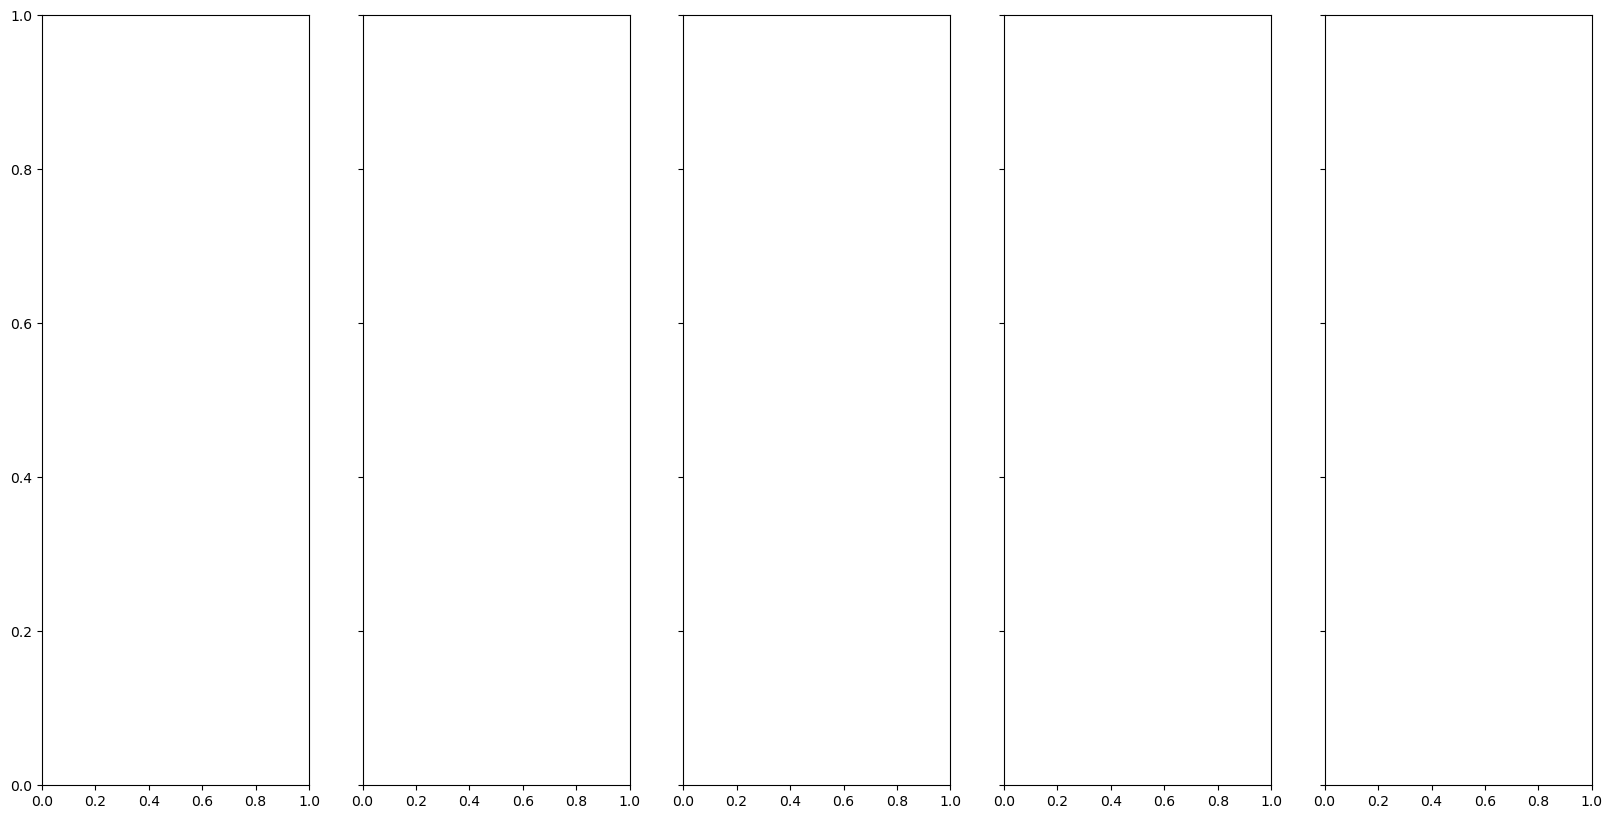

In [16]:
# Create a figure and axis
fig, ax = plt.subplots(1,5, sharey=True, figsize=(20,10))

for ii, key in enumerate(combviolin):
    
    data = combviolin[key].data.values
    names = combviolin[key].name
    # Create a violin plot of my chains
    pos = list(range(17))
    if key == 'log10(Mass)':
        toplot = [np.log10(d) for d in data]
    else:
        toplot = data
    parts = ax[ii].violinplot(toplot, pos, widths=1, showextrema=True, 
                              showmedians=True, vert=False)
    
    for pc in parts['bodies']:
        pc.set_facecolor('cornflowerblue')
        pc.set_edgecolor('cornflowerblue')
        pc.set_alpha(0.7)
    
    # overplot Sjoert's results        
    ax[ii].errorbar(combviolin[key]['median'], pos, xerr=[combviolin[key].negErr, combviolin[key].posErr], 
                    fmt='o', color='darkred', label='van Velzen et al. (2021)', capsize=3, alpha=0.5)

    # Customize the plot as needed
    ax[ii].set_yticks(pos)
    ax[ii].set_xlabel(key)
    ax[ii].set_yticklabels(names)
    #ax[ii].set_xticks(ax[ii].get_xticks(), ax[ii].get_xticklabels(), rotation=45)

#ax[0].set_xscale('log')
ax[-1].set_xscale('log')
    
#plt.show()
ax[0].legend([Line2D([0],[0],color='darkred', marker='s', linestyle='None', markersize=10, alpha=0.5), 
              Line2D([0], [0], color='cornflowerblue', marker='s', linestyle='None', markersize=10, alpha=0.5)], 
             ['van Velzen et al. (2021)', 'This Work'],
             ncols=2, bbox_to_anchor=(2.35,1.1), fontsize=18, frameon=False);

In [ ]:
np.arange(0,1)